In [1]:
%cd ../..
%pwd

/sc/arion/projects/pandeg01a/susmaa01/lei


'/sc/arion/projects/pandeg01a/susmaa01/lei'

In [2]:
import os
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm

In [11]:
configs = ['with_mode_data', 'no_mode_data']
eis = {config: [] for config in configs}
for config in configs:
    ei_dir = f"longitudinal_tadpole_v2/bps/results/no_sampling/40_5_24_{config}"
    for filename in tqdm(os.listdir(ei_dir)):
        file_path = os.path.join(ei_dir, filename)
        with open(file_path, "rb") as file:
            eis[config].append(pkl.load(file=file))

100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


In [12]:
base_sums = {config: pd.concat([ei.base_summary['metrics'] for ei in eis[config]]).groupby(level=0).mean() for config in configs}

In [13]:
def change_name(mode):
    if "MRI" in mode:
        mode = mode.split(": ")[1]
    if "Standard" in mode:
        mode = mode.replace("Standard Deviation", "STD")
    return mode

In [14]:
def change_metric_name(metric_name):
    class_dict = {0: 'CN', 1: 'MCI', 2:' Dementia'}
    if "macro" not in metric_name:
        class_label = int(metric_name.split(" ")[2])
        metric_name = metric_name.replace(f"class {class_label}", f"{class_dict[class_label]} class")
    return metric_name

In [15]:
with open("longitudinal_tadpole_v2/data/40_5/total_cohort.pkl", "rb") as file:
    total_cohort = pkl.load(file=file)

with open("longitudinal_tadpole_v2/data/40_5/core_24.pkl", "rb") as file:
    core_cohort_seqs = pkl.load(file=file)

In [16]:
def core(row):
    if row['vis_info', 'RID'] in core_cohort_seqs.index:
        if row['vis_info', 'VISCODE'] in core_cohort_seqs[row['vis_info', 'RID']]:
            return True
        else:
            return False    
    else:
        return False
core_cohort = total_cohort[total_cohort.apply(core, axis=1)].reset_index(drop=True)

In [17]:
total_splits = round(total_cohort['other', 'DX'].value_counts(normalize=True), 3)
core_splits = round(core_cohort['other', 'DX'].value_counts(normalize=True), 3)

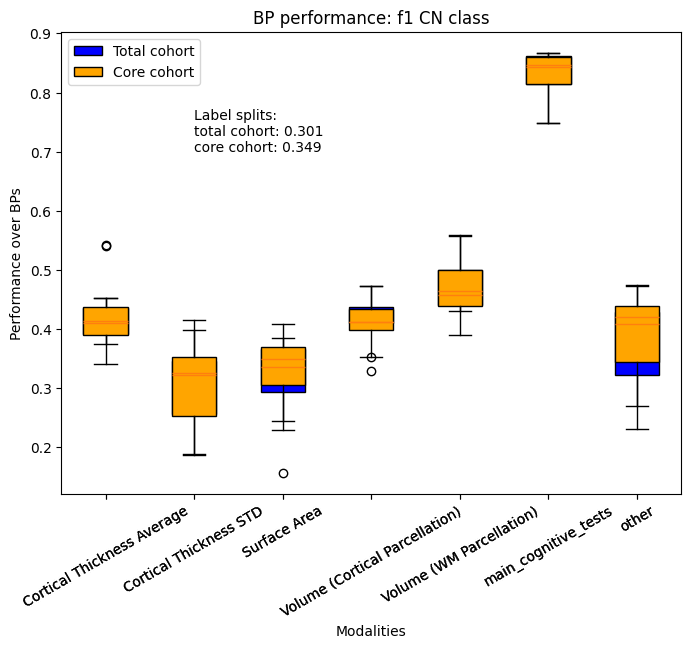

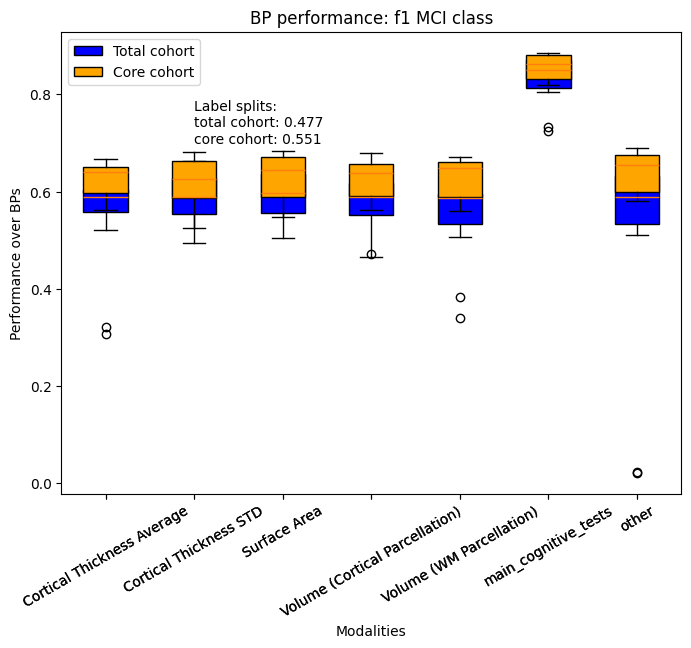

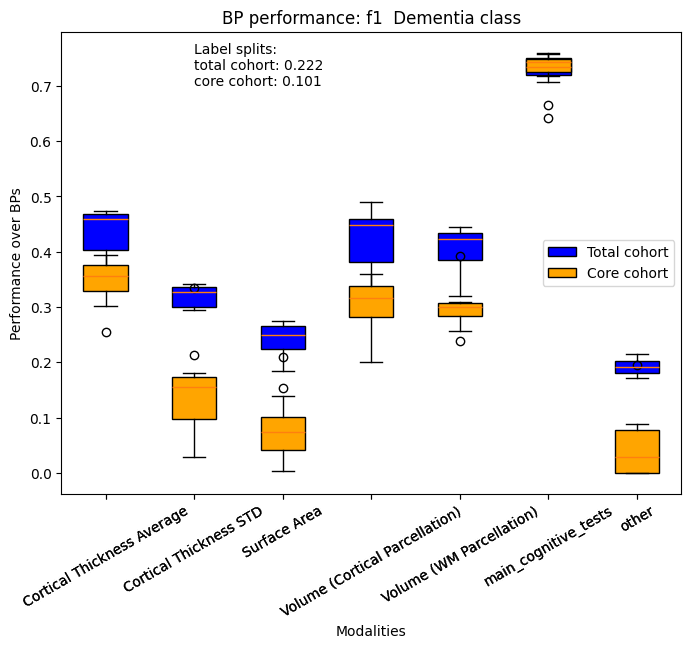

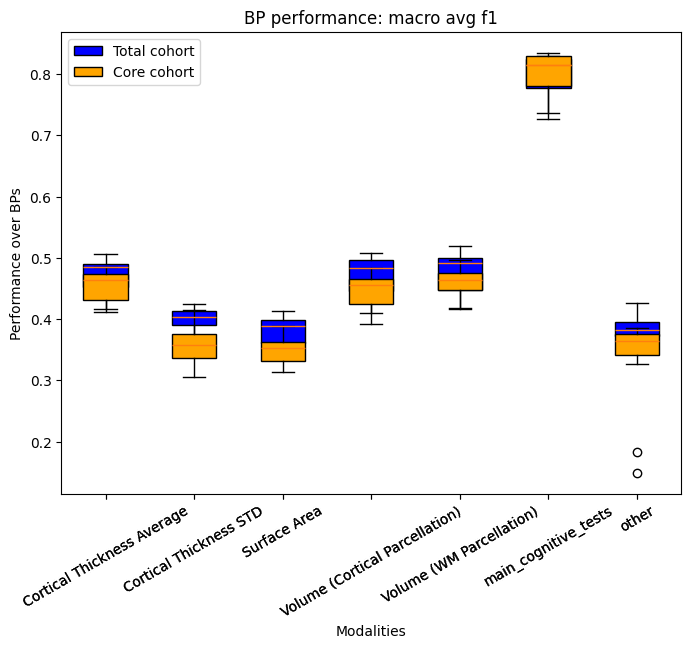

In [18]:
for metric in base_sums['no_mode_data'].index:
    df_with = pd.concat([base_sums['with_mode_data'][mode].loc[metric].rename(change_name(mode)) for mode in base_sums['with_mode_data'].columns.levels[0]], axis=1)
    # df_with['all modalities'] = base_sums['with_mode_data'].loc[metric]
    df_no = pd.concat([base_sums['no_mode_data'][mode].loc[metric].rename(change_name(mode)) for mode in base_sums['no_mode_data'].columns.levels[0]], axis=1)
    plt.figure(figsize=(8, 6))
    with_mode_data = plt.boxplot(df_with.values, labels=df_with.columns, patch_artist=True)
    no_mode_data = plt.boxplot(df_no.values, labels=df_no.columns, patch_artist=True)

    for patch in with_mode_data['boxes']:
        patch.set_facecolor('blue')
    # Set a single color for all boxes
    for patch in no_mode_data['boxes']:
        patch.set_facecolor('orange')
    plt.title(f"BP performance: {change_metric_name(metric)}")
    plt.xlabel("Modalities")
    plt.ylabel("Performance over BPs")
    plt.xticks(rotation=30)
    if 'avg' not in metric:
        f1_class = int(metric.split(" ")[2])
        total_class = total_splits[f1_class]
        core_class = core_splits[f1_class]
        plt.text(2,0.7,f'Label splits:\ntotal cohort: {total_class}\ncore cohort: {core_class}')
    legend_patches = [mpatches.Patch(facecolor='blue', edgecolor='black', label='Total cohort'),
                      mpatches.Patch(facecolor='orange', edgecolor='black', label='Core cohort')]
    plt.legend(handles=legend_patches)
    plt.show()